In [9]:
import pandas as pd
import psutil
import os
from nba_common_library.utils import utils
from nba_common_library.lib_string import *
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
import warnings
import numpy as np
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import Season
from nba_api.stats.library.parameters import SeasonType
from nba_api.stats.endpoints import playbyplay

warnings.filterwarnings("ignore")
pd.options.display.float_format = lambda x: '{:.0f}'.format(x) if abs(x) > 1 else '{:.2f}'.format(x)

Recovering data aggregated by @Raphael
/!\ PS : le header a été modifié au préalable avec la fonction convention_rename du sous-module utils /!\

In [5]:
database_path = os.path.join(project_path, 'data.nosync')  ##data.nosync == data (le nosync m'évite le déchargement automatique d'icloud)

# Importation des données
# J'utilise 10% de ma mémoire pour l'ouverture du fichier d'1.4Go pour pas faire planter mon ordi
chunk_size = int(psutil.virtual_memory().available * 0.1 / 1e6)
chunk_list = []
for chunk in pd.read_csv(os.path.join(database_path, 'shot_data_merged.csv'), chunksize=chunk_size):
    chunk_list.append(chunk)

df = pd.concat(chunk_list)

# Réécriture des date de match au format datetime
df['game_date'] = pd.to_datetime(df['game_date'], format='%Y%m%d')

# Separation par années civile
data_per_year = {}
for year in df['game_date'].dt.year.unique():
    data_per_year[year] = df.loc[df['game_date'].dt.year == year]

# On utilise les données de l'année 2019 seulement pcq
# la différence du jeu inclus un biais et pour reduire la taille du jeu de données
current_data = data_per_year[list(data_per_year.keys())[-1]]

for key, table in data_per_year.items():
    print(f'{key:_<30} {table.shape}')

2000__________________________ (64942, 60)
2001__________________________ (177503, 60)
2002__________________________ (180215, 60)
2003__________________________ (179267, 60)
2004__________________________ (177481, 60)
2005__________________________ (189182, 60)
2006__________________________ (191376, 60)
2007__________________________ (190193, 60)
2008__________________________ (194823, 60)
2009__________________________ (192218, 60)
2010__________________________ (194400, 60)
2011__________________________ (125921, 60)
2012__________________________ (218822, 60)
2013__________________________ (195307, 60)
2014__________________________ (198124, 60)
2015__________________________ (197530, 60)
2016__________________________ (201641, 60)
2017__________________________ (196883, 60)
2018__________________________ (172755, 60)
2019__________________________ (89515, 60)


# data informations

In [8]:
# Description statistique
current_data.describe()

,unnamed,game_id,game_event_id,player_id,team_id,period,minutes_remain,seconds_remain,shot_distance,shot_x_location,...,period.1,person_1_type,person_2_type,person_3_type,player_1_id,player_1_team_id,player_2_id,player_2_team_id,player_3_id,player_3_team_id
count,"89,515.00","89,515.00","89,515.00","89,515.00","89,515.00","89,515.00","89,515.00","89,515.00","89,515.00","89,515.00",...,"89,515.00","89,515.00","89,515.00","89,515.00","89,515.00","89,515.00","89,515.00","24,919.00","89,515.00","4,650.00"
mean,"3,483,340.00","21,800,889.17",323.88,"496,375.11","1,610,612,751.89",2.47,5.35,28.87,13.14,-1.25,...,2.47,4.50,1.25,0.23,"496,375.11","1,610,612,751.89","189,161.87","1,610,612,751.81","40,012.67","1,610,612,751.88"
std,"25,840.90",195.48,196.21,"590,891.01",8.53,1.13,3.46,17.42,10.56,108.30,...,1.13,0.50,2.03,1.00,"590,891.01",8.53,"472,243.63",8.53,"234,781.11",8.47
min,"3,438,583.00","21,800,549.00",7.00,"1,713.00","1,610,612,737.00",1.00,0.00,0.00,0.00,-248.00,...,1.00,4.00,0.00,0.00,"1,713.00","1,610,612,737.00",0.00,"1,610,612,737.00",0.00,"1,610,612,737.00"
25%,"3,460,961.50","21,800,720.00",152.00,"201,942.00","1,610,612,745.00",1.00,2.00,14.00,2.00,-44.00,...,1.00,4.00,0.00,0.00,"201,942.00","1,610,612,745.00",0.00,"1,610,612,744.00",0.00,"1,610,612,745.00"
50%,"3,483,340.00","21,800,891.00",322.00,"203,083.00","1,610,612,751.00",2.00,5.00,29.00,12.00,0.00,...,2.00,5.00,0.00,0.00,"203,083.00","1,610,612,751.00",0.00,"1,610,612,751.00",0.00,"1,610,612,752.00"
75%,"3,505,718.50","21,801,058.00",488.00,"203,967.00","1,610,612,760.00",3.00,8.00,44.00,24.00,42.00,...,3.00,5.00,4.00,0.00,"203,967.00","1,610,612,760.00","201,142.00","1,610,612,760.00",0.00,"1,610,612,759.00"
max,"3,528,097.00","21,801,230.00",986.00,"1,628,021.00","1,610,612,766.00",8.00,12.00,59.00,83.00,248.00,...,8.00,5.00,5.00,5.00,"1,628,021.00","1,610,612,766.00","1,629,541.00","1,610,612,766.00","1,629,244.00","1,610,612,766.00"


In [10]:
# Types des variables
current_data.dtypes

unnamed                            int64
game_id                            int64
game_event_id                      int64
player_id                          int64
player_name                       object
team_id                            int64
team_name                         object
period                             int64
minutes_remain                     int64
seconds_remain                     int64
action_type                       object
shot_type                         object
shot_zone_basic                   object
shot_zone_area                    object
shot_zone_range                   object
shot_distance                      int64
shot_x_location                    int64
shot_y_location                    int64
shot_made_flag                     int64
game_date                 datetime64[ns]
home_team                         object
away_team                         object
season_type                       object
height                           float64
weight          

In [11]:
# Quantité de valeurs manquantes
current_data.isna().sum() / current_data.shape[0]

unnamed                                  0.00
game_id                                  0.00
game_event_id                            0.00
player_id                                0.00
player_name                              0.00
team_id                                  0.00
team_name                                0.00
period                                   0.00
minutes_remain                           0.00
seconds_remain                           0.00
action_type                              0.00
shot_type                                0.00
shot_zone_basic                          0.00
shot_zone_area                           0.00
shot_zone_range                          0.00
shot_distance                            0.00
shot_x_location                          0.00
shot_y_location                          0.00
shot_made_flag                           0.00
game_date                                0.00
home_team                                0.00
away_team                         

In [9]:
# Assignation des variables en fonction du type
numeric_col = [col for col in current_data.columns if current_data[col].dtype != 'object']
categoric_col = [col for col in current_data.columns if current_data[col].dtype == 'object']

In [13]:
# Quantité de modalité pour les variables de type numeric
current_data[numeric_col].nunique()

unnamed                  89515
game_id                    682
game_event_id              848
player_id                  306
team_id                     30
period                       8
minutes_remain              13
seconds_remain              60
shot_distance               78
shot_x_location            496
shot_y_location            543
shot_made_flag               2
game_date                   93
height                      16
weight                      44
dob                         34
event_msg_action_type       46
event_msg_type               2
neutral_description          0
period.1                     8
person_1_type                2
person_2_type                3
person_3_type                3
player_1_id                306
player_1_team_id            30
player_2_id                482
player_2_team_id            30
player_3_id                430
player_3_team_id            30
dtype: int64

In [14]:
# Quantité de modalité pour les variables de type object
current_data[categoric_col].nunique()

player_name                 306
team_name                    30
action_type                  46
shot_type                     2
shot_zone_basic               7
shot_zone_area                6
shot_zone_range               5
home_team                    30
away_team                    30
season_type                   1
college                      97
birth_city                  208
birth_state                  69
home_description          32154
pc_timestring               717
player_1_name               306
player_1_team_abb            30
player_1_team_city           30
player_1_team_nickname       30
player_2_name               481
player_2_team_abb            30
player_2_team_city           30
player_2_team_nickname       30
player_3_name               429
player_3_team_abb            30
player_3_team_city           30
player_3_team_nickname       30
score                      6359
score_margin                155
visitor_description       32950
wc_timestring               795
dtype: i

Analyse des performances antérieures des tirs par joueurs

In [18]:
from nba_common_library.scrappers.bb_ref_scrap import get_bb_stats
from nba_common_library.scrappers.nba_scrap import get_nba_stats
from nba_common_library.scrappers.merge_sources import get_id_corr

bb_ref_stats_2019 = get_bb_stats(2019)
nba_ref_stats_2019 = get_nba_stats(2019)
correspondancy_table = get_id_corr(2019)

# https://www.basketball-reference.com/leagues/NBA_2019_totals.html

In [89]:
from basketball_reference_web_scraper import client

def get_player_score(nba_ref_id, season_year, n_last=None):
    try:
        stats_df = pd.DataFrame(client.regular_season_player_box_scores(player_identifier=nba_ref_id, season_end_year=season_year)).sort_values(by='date', ascending=False)

        if n_last is not None:
            stats_df = stats_df.head(n_last)

        seconds_played = stats_df.seconds_played.sum()

        fg_attempted = stats_df.attempted_field_goals.sum()
        fg_made = stats_df.made_field_goals.sum()
        fg_score = (fg_made / fg_attempted / seconds_played) * 100000 if fg_attempted else 0

        fg3_attempted = stats_df.attempted_three_point_field_goals.sum()
        fg3_made = stats_df.made_three_point_field_goals.sum()
        fg3_score = (fg3_made / fg3_attempted / seconds_played) * 100000 if fg3_attempted else 0

        ft_attempted = stats_df.attempted_free_throws.sum()
        ft_made = stats_df.made_free_throws.sum()
        ft_score = (ft_made / ft_attempted / seconds_played) * 100000 if ft_attempted else 0

        return fg_score, fg3_score, ft_score

    except:
        return np.nan


get_player_score("goberru01", 2019)
#2pts_score, 3pts_score, lancer_franc_score

(0.43242325559186856, 0, 0.41138614753303504)

In [24]:
correspondancy_dict = correspondancy_table.set_index('nba_id')['bbref_id'].to_dict()
current_data['bbref_id'] = current_data.player_id.map(correspondancy_dict)

In [36]:
bb_ref_stats_2019['fg_norm'] = (bb_ref_stats_2019['Field Goal Percentage']/ bb_ref_stats_2019['Minutes Played']) * 100
bb_ref_stats_2019['fg3_norm'] = (bb_ref_stats_2019['3-Point Field Goal Percentage']/ bb_ref_stats_2019['Minutes Played']) * 100

In [44]:
current_data['fg_percent'] = current_data.bbref_id.map(bb_ref_stats_2019.set_index('id')['fg_norm'].to_dict())
current_data['fg3_percent'] = current_data.bbref_id.map(bb_ref_stats_2019.set_index('id')['fg3_norm'].to_dict())

In [47]:
current_data[['fg_percent','fg3_percent']] = current_data[['fg_percent','fg3_percent']].fillna(0)

Analyse de l'adversité sur tir

In [38]:
# Assignation des postes aux joueurs concernées par les actions
from nba_common_library.utils.utils import map_position

map_position_assign = map_position()
for year in data_per_year.keys():
    data_per_year[year]['player_1_position'] = data_per_year[year]['player_1_name'].map(map_position_assign)
    data_per_year[year]['player_2_position'] = data_per_year[year]['player_2_name'].map(map_position_assign)
    data_per_year[year]['player_3_position'] = data_per_year[year]['player_3_name'].map(map_position_assign)

In [40]:
#Création des duels avantage 2contre1 ou 1 contre 2
def dual_situation(row):
    row = row[['player_1_team_id','player_2_team_id','player_3_team_id' ]]
    return f'{sum(row == row[0])}v{len(row.dropna()) - sum(row == row[0])}'

current_data['situation'] = current_data.apply(dual_situation, axis=1)
current_data['situation'].value_counts(normalize=True)

1v0   0.67
2v0   0.28
1v1   0.05
Name: situation, dtype: float64

In [41]:
current_data['is_defended'] = current_data['situation'].apply(lambda x: x[-1])
current_data.groupby(['is_defended','shot_made_flag']).count().iloc[:,1]

# Il semble n'exister aucun tir réussi si défenseur il y a
# Lorsque le tir est sans defenseur il y a une probabilité d'approximativement 0.5 de marquer
# -- A approfondir

is_defended  shot_made_flag
0            0                 43174
             1                 41691
1            0                  4650
Name: game_id, dtype: int64

In [42]:
current_data.groupby(['player_1_position','is_defended','shot_made_flag']).count().iloc[:,1].unstack(-1)

# Je suppose que la présence du defenseur est spécifiée uniquement lorsque sa présence permet la non reussite du tir autrement elle n'est pas indiquée
# -- A explorer davantage

shot_made_flag                    0    1
player_1_position is_defended           
C                 0            5978 8226
                  1             958  NaN
PF                0            6783 6881
                  1             709  NaN
PG                0           10334 8748
                  1             995  NaN
SF                0            8888 8236
                  1             977  NaN
SG                0           11027 9493
                  1            1003  NaN

Analyse de la postion du tir :

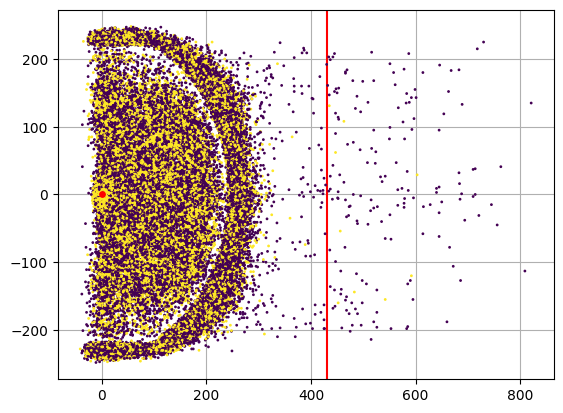

In [296]:
plt.grid(zorder=0)
plt.scatter(current_data['shot_y_location'], current_data['shot_x_location'], s=1, c=current_data['shot_made_flag'], zorder=10)
plt.scatter(hoop_x, hoop_y, s=15, c='r', zorder=11)
plt.axvline(430, color='r')
plt.show();
#Drop outliers demi terrain +430 pied ?

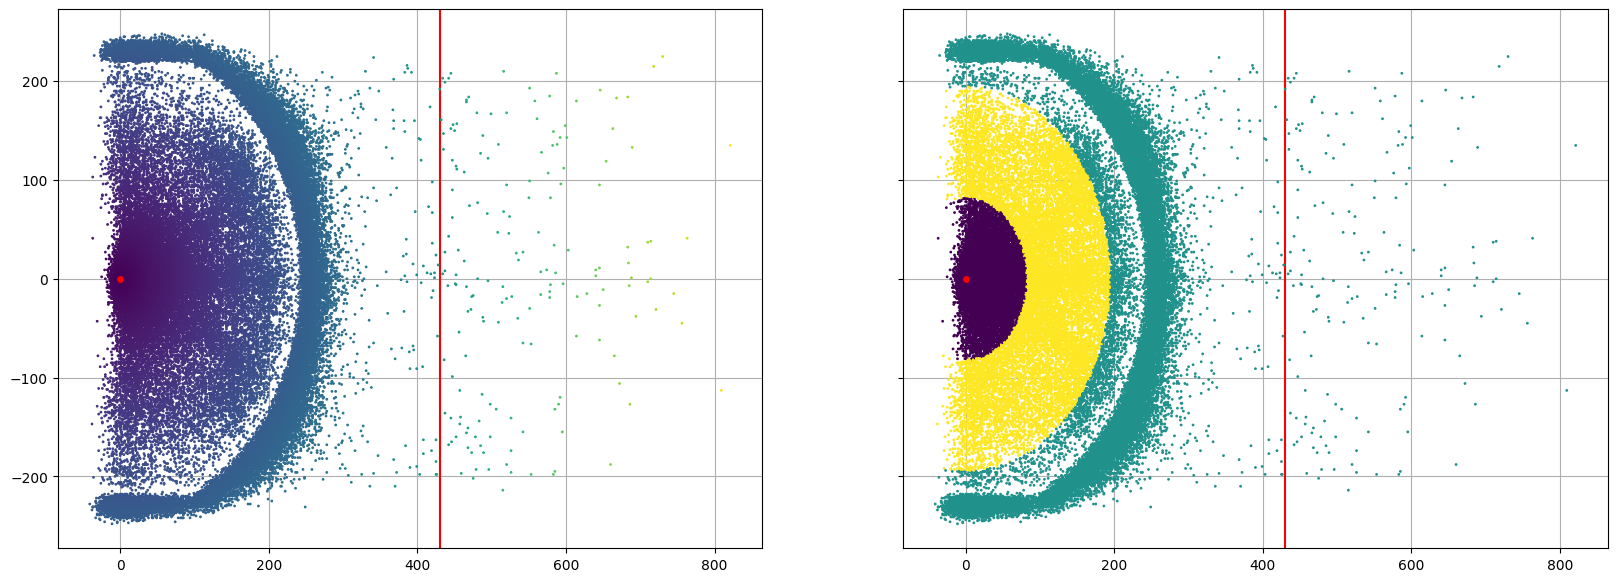

In [297]:
from nba_common_library.utils.utils import get_shooting_distance
current_data['shot_distance'] = current_data.apply(lambda x: get_shooting_distance(x['shot_x_location'], x['shot_y_location']), axis=1)
current_data['shot_distance_grouped'] = KMeans(n_clusters=3, random_state=0).fit(current_data[['shot_distance']]).labels_

fig, ax = plt.subplots(1, 2, figsize=(20, 7), sharex=True, sharey=True)

for axs, key in zip(ax.flatten(), ['shot_distance', 'shot_distance_grouped'] ):
    axs.grid(zorder=0)
    axs.scatter(current_data['shot_y_location'], current_data['shot_x_location'], s=1, c=current_data[key], zorder=10)
    axs.scatter(0, 0, s=15, c='r', zorder=11)
    axs.axvline(430, color='r')
fig.show()

In [303]:
contingency_table = pd.crosstab(current_data['shot_made_flag'], current_data['shot_distance_grouped'])
statistic, p_value, dof, expected = chi2_contingency(contingency_table)
p_value < 0.05

True

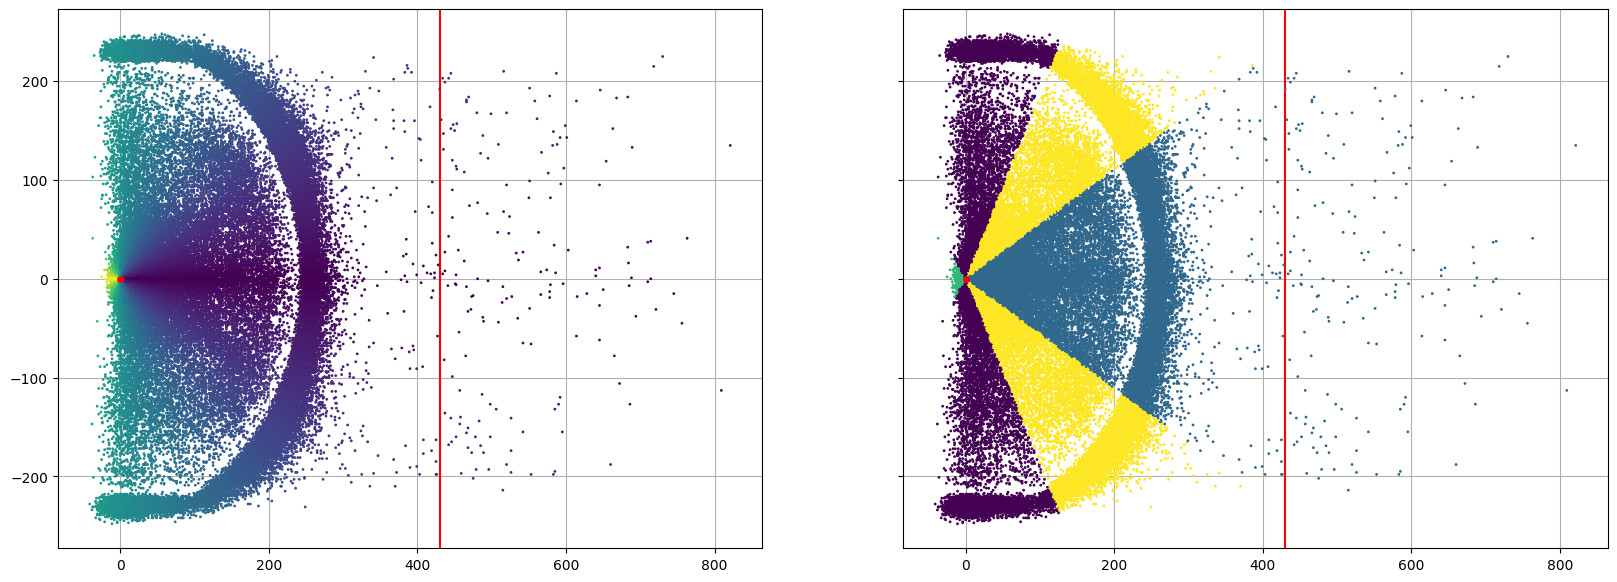

In [289]:
from nba_common_library.utils.utils import get_shooting_angle

current_data['shot_angle'] = current_data.apply(lambda x: get_shooting_angle(x['shot_x_location'], x['shot_y_location']), axis=1)
current_data['shot_angle_grouped'] = KMeans(n_clusters=4, random_state=0).fit(current_data[['shot_angle']]).labels_

fig, ax = plt.subplots(1, 2, figsize=(20, 7), sharex=True, sharey=True)

for axs, key in zip(ax.flatten(), ['shot_angle', 'shot_angle_grouped'] ):
    axs.grid(zorder=0)
    axs.scatter(current_data['shot_y_location'], current_data['shot_x_location'], s=1, c=current_data[key], zorder=10)
    axs.scatter(0, 0, s=15, c='r', zorder=11)
    axs.axvline(430, color='r')
fig.show()

In [302]:
contingency_table = pd.crosstab(current_data['shot_made_flag'], current_data['shot_angle_grouped'])
statistic, p_value, dof, expected = chi2_contingency(contingency_table)
p_value < 0.05

True

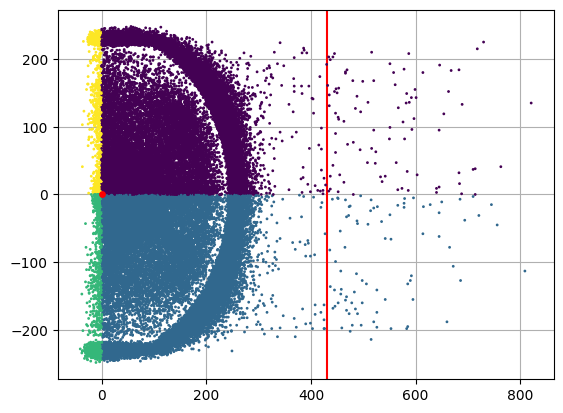

In [290]:
from nba_common_library.utils.utils import get_shooting_quadrant

current_data['quadrant'] = current_data.apply(lambda x: get_shooting_quadrant(x['shot_x_location'], x['shot_y_location']), axis=1)
plt.grid(zorder=0)
plt.scatter(current_data['shot_y_location'], current_data['shot_x_location'], s=1, c=current_data['quadrant'], zorder=10)
plt.scatter(0, 0, s=15, c='r', zorder=11)
plt.axvline(430, color='r');

Analyse de la fatigue :

In [ ]:
# Temps joué ?
# Temps joué sur les dernier match ?
# Dernier match
# Back to back ?

Analayse de la physionomie du match :

In [ ]:
# Score au moment du tir ?
# Avantage au score ?
# margin ?

Analyse du type de tir :

In [13]:
#Type de tirs effectué
current_data['shoot_type'] = list(map(lambda x: next((key for key, values in shoot_types.items() if x in values), x), current_data['action_type']))
current_data['shoot_type'].value_counts(normalize=True)


jump_shoot   0.60
layup        0.27
turnaround   0.07
dunk         0.06
Name: shoot_type, dtype: float64

Analyse de la temporalité du tir :

In [ ]:
# Chronomètre du match (début ? fin ? buzzer?)

Fast modelling

In [58]:
current_data["is_defended"]

3438583    0
3438584    0
3438585    0
3438586    0
3438587    0
          ..
3528093    0
3528094    0
3528095    0
3528096    0
3528097    0
Name: is_defended, Length: 89515, dtype: object

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = current_data[['shoot_type', 'quadrant', 'shot_angle_grouped', 'shot_distance_grouped', 'fg_percent', 'fg3_percent', 'is_defended']]
X = pd.get_dummies(X, columns=['shoot_type', 'quadrant' ], prefix=['shoot_type', 'quadrant'], drop_first=True)
y = current_data['shot_made_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [55]:
dtc = DecisionTreeClassifier(max_depth=15)
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69      9565
           1       0.64      0.50      0.57      8338

    accuracy                           0.64     17903
   macro avg       0.64      0.63      0.63     17903
weighted avg       0.64      0.64      0.63     17903

[[7220 2345]
 [4131 4207]]


In [56]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.64      0.79      0.71      9565
           1       0.67      0.49      0.57      8338

    accuracy                           0.65     17903
   macro avg       0.66      0.64      0.64     17903
weighted avg       0.66      0.65      0.64     17903

[[7577 1988]
 [4259 4079]]


In [ ]:
import xgboost as xgb
X_train['is_defended'] = X_train['is_defended'].astype('category')
X_test['is_defended'] = X_test['is_defended'].astype('category')

dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
model = xgb.train(dtrain=dtrain, num_boost_round=100)

dtest = xgb.DMatrix(data=X_test, enable_categorical=True)
pred = np.round(model.predict(dtest))

print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))